In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
from IPython.display import clear_output
from random import shuffle
from collections import defaultdict
from utils import getTransitions_and_Rewards

In [3]:
%matplotlib inline

The training of the classifier is done on the Two-rooms grid, in the purpose is to determine the classifier settings to be used in settings similar to the training one

## Two rooms grid

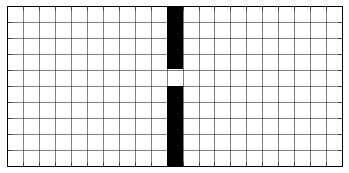

In [7]:
grid = np.zeros((10,21))
grid[:,10] = -1
grid[4,10] =  0
GOAL = (9,20)
WESTregion_LIMIT = 10 #not included 
plt.imshow(grid, cmap='gray', interpolation='nearest', extent = [0,21,0,10])
ax = plt.gca();
ax.set_xticks(np.arange(0,21, 1));
ax.set_yticks(np.arange(0, 10, 1));
ax.set_xticklabels([]);
ax.set_yticklabels([]);
plt.grid(color='black', which = 'major', linestyle='-')
plt.savefig("2rooms.png", bbox_inches='tight')
plt.show()

* actions  = [up,down,right,left]
* If against the wall, the position stays the same


In [11]:
trans, _ = getTransitions_and_Rewards(grid, GOAL)

## Determine class conditional *relative novelty scores* distributions:

In [12]:
novelty     = lambda s: 1.0/np.sqrt(nbVisits[s])

set_novelty = lambda S: 1.0/np.sqrt(nbVisits[np.array([s[0] for s in S]), np.array([s[1] for s in S])].mean())  

def rel_novelty(prev_sequence, succ_sequence):
    return float(set_novelty(succ_sequence)) / set_novelty(prev_sequence)

In [13]:
ln = 7 #according to the paper

scores_per_run = defaultdict(list)
stateList = [(i,j) for i in range(10) for j in range(21)]

for run in range(1000):
    nbVisits = np.zeros((10,21))
    scores = defaultdict(list)
    
    clear_output()
    print "RUN:", run
    sys.stdout.flush()
    
    state = stateList[np.random.choice(range(len(stateList)))]
    while grid[state] <0:
        state = stateList[np.random.choice(range(len(stateList)))]
    states_visited = [state]   
    
    for step in range(1000):
            nextState = trans[state][np.random.choice(range(4))]
            """
            keep track of states visited to compute relative novelty scores
            """
            if nextState != state:
                states_visited.append(nextState)
                nbVisits[nextState]+=1
            
            "Update novelty score of states visited nlag steps before "
            if len(states_visited) >= (2*ln):
                prec_seq = states_visited[-2*ln:-ln]
                succ_seq = states_visited[-ln:]
                state2update = states_visited[-ln]
                score = rel_novelty(prec_seq, succ_seq)               
                scores[state2update].append(score)                
              
            state = nextState    
    for state in stateList:
        if grid[state] < 0:
            continue
        scores_per_run[(state)].append(scores[state])

RUN: 999


In [14]:
scores_tot = defaultdict(list)
for state in stateList:
    if grid[state] < 0:
        continue
    scores_tot[state] = [val for sublist in scores_per_run[state] for val in sublist]

In [15]:
class_scores = []
class_scores.append( scores_tot[(4,10)] )
class_scores.append( scores_tot[state] for state in stateList if state!= (4,10) and grid[state]>=0 )

In [16]:
class_scores[1] = [val for sublist in class_scores[1] for val in sublist]

In [17]:
t = np.histogram(class_scores[0], bins=np.arange(0,5,0.05))
nt= np.histogram(class_scores[1], bins=np.arange(0,5,0.05))

In [18]:
t_n  = np.array([float(x)/np.sum(t[0]) for x in t[0]])
nt_n = np.array([float(x)/np.sum(nt[0]) for x in nt[0]])

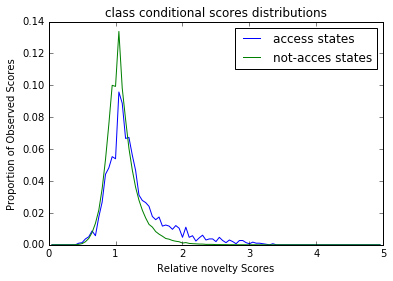

In [19]:
plt.plot(t[1][1:], t_n, label='access states')
plt.plot(nt[1][1:], nt_n, label = 'not-acces states')
plt.legend()
plt.title("class conditional scores distributions")
plt.xlabel('Relative novelty Scores')
plt.ylabel('Proportion of Observed Scores')
plt.savefig('distrib.png', bbox_inches='tight')
plt.show()

## Determine t-RN    

In [21]:
t_RN_values = np.arange(0.5,3,0.5)

In [22]:
class_scores_tuples = []
class_scores_tuples.append([(1, score) for score in class_scores[0]])
class_scores_tuples.append([(0, score) for score in class_scores[1]])

labeled_scores = [val for val in class_scores_tuples[0]+class_scores_tuples[1]]

In [23]:
labeled_scores_sorted = sorted(labeled_scores, key=lambda t: -t[1])

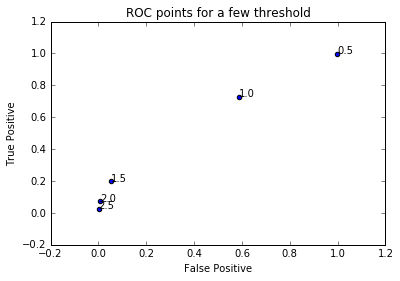

In [27]:
fig, ax = plt.subplots()

for t in t_RN_values:
    binary_target = np.array(class_scores[0])
    binary_target[binary_target<t]  = 0
    binary_target[binary_target>=t] = 1
    
    
    binary_not_target = np.array(class_scores[1])
    binary_not_target[binary_not_target<t]  = 0
    binary_not_target[binary_not_target>=t] = 1
    
    
    tp_perc = (binary_target==1).sum()/float(len(class_scores[0]))    
    fp_perc = ((binary_not_target==1).sum() )/ float(len(class_scores[1]))    
    ax.scatter(fp_perc, tp_perc)
    ax.annotate(t, (fp_perc, tp_perc))
plt.xlabel('False Positive')
plt.ylabel("True Positive")
plt.title('ROC points for a few threshold')
plt.savefig('roc.png', bbox_inches='tight')
plt.show()

Since avoiding False Positive examples is more important than having many True Positive examples, we decide to choose a threshold that minimize the number of False Positive as much as possible. Consistently with the results of *Simsek, Barto (2004)*, we find that 2 is a good value for $t_{RN}$

## Determinine p,q

After we choose a threshold $t_{RN}$, we can transform each relative novelty score to a binary feature $x$, where $x=1$ if $score>t_{RN}$, and 0 otherwise

$$
p = P\{x=1|T\}
$$

$$ q = P\{x=1|N\}  $$

In [17]:
t_RN = 2

target = np.array(class_scores[0])
p = (target>= t_RN).sum() / float(target.shape[0])

not_target = np.array(class_scores[1])
q = (not_target>= t_RN).sum() / float(not_target.shape[0])

print p
print q

0.0756273633551
0.00644149072466


The results are very similar to the one reported by *Simsek, Barto (2004)* : *p = 0.0712* and *q=0.0056*, with the small differences probably due to the randomness in the procedure

## Costs and Priors ratios

Since only some guidelines are provided to determine these  values, we decide to use the ones of *Simsek, Barto (2004)*

## References

[1]  Şimşek, Özgür, and Andrew G. Barto. *"Using relative novelty to identify useful temporal abstractions in reinforcement learning."* Proceedings of the twenty-first international conference on Machine learning. ACM, 2004.